In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import pickle
import datetime

# name = "image-256x64{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = os.path.join("logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

categories=["NORMAL","PNEUMONIA"] 


In [7]:
img_size = 150


def create_train(datadir):
    data=[]
    for category in categories:
        path = os.path.join(datadir, category)
        class_num=categories.index(category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([new_arr, class_num])
            except Exception as e:
                pass
    return np.array(data)
train=create_train("D:/datasets/chest_xray/chest_xray/train")
test=create_train("D:/datasets/chest_xray/chest_xray/test")
val=create_train("D:/datasets/chest_xray/chest_xray/val")


In [8]:
print(len(train))
print(len(test))
print(len(val))

print(train[0][0].shape)

5216
624
16
(150, 150)


In [9]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 1:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)


Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


NORMAL
<attribute 'shape' of 'numpy.ndarray' objects>
(2,)


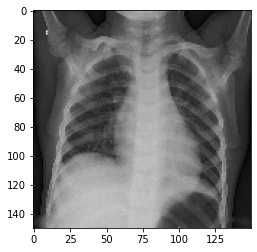

In [10]:
plt.imshow(train[1340][0], cmap='gray')
print(categories[train[1340][1]])
print(type(train).shape)
print(train[0].shape)

In [13]:
from sklearn.model_selection import train_test_split
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [14]:
X_train.shape

(4684, 150, 150, 1)

In [19]:
X_train = X_train / 255
X_test = X_test / 255

In [20]:
config =tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# early_stop = EarlyStopping(patience=3, monitor='val_loss')
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [21]:
model.fit(X_train, y_train, batch_size=15, epochs=10, validation_split=0.25, callbacks=[tensorboard])

Train on 3513 samples, validate on 1171 samples
Epoch 1/10
3513/3513 [==============================] - 16s 5ms/sample - loss: 0.3481 - acc: 0.8753 - val_loss: 0.6256 - val_acc: 0.7421
Epoch 2/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.2383 - acc: 0.9246 - val_loss: 0.4375 - val_acc: 0.8241
Epoch 3/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.2112 - acc: 0.9274 - val_loss: 0.1448 - val_acc: 0.9471
Epoch 4/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.1983 - acc: 0.9379 - val_loss: 0.1201 - val_acc: 0.9624
Epoch 5/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.1988 - acc: 0.9351 - val_loss: 0.1594 - val_acc: 0.9539
Epoch 6/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.2010 - acc: 0.9340 - val_loss: 0.1498 - val_acc: 0.9530
Epoch 7/10
3513/3513 [==============================] - 11s 3ms/sample - loss: 0.1820 - acc: 0.9436 - val_loss: 0.2034 - val_acc: 

In [23]:
import math
prediction = model.predict(X_test)
print(prediction.shape)
i=0
for a  in prediction:
    if a>1:
        print(0, y_test[i])  # will be a list in a list.
    else:
        print(np.around(a), y_test[i])
    i+=1


(1172, 1)
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 1
[0.] 0
[1.] 1
[0.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 0
[1.] 1
[0.] 0
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 0
[0.] 0
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[0.] 0
[1.] 1
[0.] 0
[1.] 1
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[0.] 0
[1.] 0
[1.] 1
[1.] 1
[1.] 1
[1.] 0
[0.] 0
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[0.] 0
[1.] 1
[1.] 1
[1.